In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
from __future__ import division, print_function
import os
import gc
import numpy as np
import h5py as hdf
from scipy.misc import imread, imsave
import pyzdde.zdde as py
import pyzdde.arraytrace as at
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes

# local modules
import iutils.plot.mplutils as mplu

In [4]:
#local module
%aimport geometric_model_zemax_commons
import geometric_model_zemax_commons as gm

In [5]:
%matplotlib inline
#%matplotlib notebook

In [6]:
curDir = os.getcwd()

In [7]:
# Location of the Zemax lens files for this notebook
zmxdir = os.path.join(curDir, 'zmxfiles')
ln = pyz.createLink()

Could not initiate instance.


ERROR: Unable to establish a conversation with server (err=0x400aL).
ZEMAX may not be running!


In [8]:
lens = "paraxialDoubleLens24mmFiniteConj_mp2.zmx"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)

0

In [14]:
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ STANDARD       Infinity            500                                200              0
   1 PARAXIAL              -       3.636364                           9.382086              - Lens 1
 STO STANDARD       Infinity       16.36364                           7.142857              0 Stop
   3 PARAXIAL              -       13.17073                           11.35204              - Lens 2
 IMA STANDARD       Infinity                                          9.756098              0


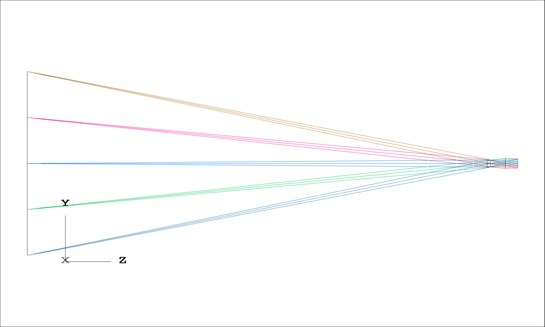

In [15]:
ln.ipzCaptureWindow('L3d')

In [16]:
# First order parameters
ln.ipzGetFirst()

Paraxial magnification : -0.0487804878
Real working F/#       : 3.168743031
Effective focal length : 24.0
Paraxial working F/#   : 3.129046563
Paraxial image height  : 4.87804878


In [17]:
# Pupil information
ln.ipzGetPupil()

Exit pupil position (from IMA)           : -49.17073171
Entrance pupil position (from surface 1) : 4.0
Aperture Type                            : Float by stop
Apodization factor                       : 0.0
Apodization type                         : None
Value (stop surface semi-diameter)       : 3.571428571
Exit pupil diameter                      : 15.71428571
Entrance pupil diameter                  : 7.857142857


In [18]:
ln.zGetPupilMagnification()

1.999999999490909

In [16]:
#ln.zPushLens()

In [17]:
# Draw ENPP, EXPP and cardinal surfaces
gm.draw_pupil_cardinal_planes(ln, firstDummySurfOff=20, push=True)

Textual information about the planes:

Exit pupil distance from IMG: -49.17073171
Entrance pupil from Surf 1 @ LDE: 24.0
Focal plane obj F from surf 1 @ LDE:  12.0 
Focal plane img F' from IMA:  -1.170732
Principal plane obj H from surf 1 @ LDE:  36.0 
Principal plane img H' from IMA:  -25.170732
Focal length:  24.0
Principal plane H to ENPP:  12.0
Principal plane H' to EXPP:  23.99999971
Principal plane H' to EXPP (abs.) calc. using lens equ.:  24.0
Principal plane H' to rear focal plane:  24.0
Principal plane H to front focal plane:  -24.0

Check "Skip rays to this surface" under "Draw Tab" of the surface property for the dummy and cardinal plane surfaces. See Docstring Notes for details.


In [24]:
# After making the required changes to the surface properties (skip rays)
# in the Zemax main application window, the file with the new surfaces
# to show the position of the pupils and cardinal planes was saved as
# paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawn.zmx
# For drawing the figure, we can use a stored copy in order to avoid
# manually changing surface properties in the LDE again and again
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawn.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

In [25]:
#ln.zPushLens()

In [26]:
# Insert appropriate coordinate breaks to tilt the lens
cb1, cb2 = gm.insert_cbs_to_tilt_lens(ln, lastSurf=16, firstSurf=2, pivot='ENPP', offset=5, push=True)
cb1, cb2

(4, 20)

As before, we need to do the following:

1. In the main Zemax application, check the "Skip rays to this surface" for the two dummy surfaces just inserted -- one preceding the first CB and second following the second CB -- in the "Draw Tab" under surface properties.

2. Fix the semi-diameters of the ENPP and EXPP surfaces so that they don't change when the lens rotates.

3. Ensure that the global reference surface is either the PIVOT surface (recommended), image plane or the untilted object plane.

4. Also, ensure that you are displaying all the appropriate surfaces in the LDE. 

In [49]:
# Helper functions

def find_surf_using_comment(ln, comment):
    for i in range(ln.zGetNumSurf()):
        if ln.zGetComment(i) == comment:
            break
    else:
        return -1
    return i

def get_pupil_pos_from_pivot(ln):
    """returns the distance of the ENPP and EXPP from the PIVOT
    """
    ln.zGetUpdate()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    enppSurf = find_surf_using_comment(ln, 'ENPP')
    exppSurf = find_surf_using_comment(ln, 'EXPP')

    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    enppZ = ln.zOperandValue('GLCZ', enppSurf) - pivotZ
    exppZ = ln.zOperandValue('GLCZ', exppSurf) - pivotZ
    return enppZ, exppZ, pivotZ

def get_image_pos_from_pivot(ln):
    """returns the distance of the image plane from the pivot along z-direction"""
    ln.zGetUpdate()
    imaSurf = ln.zGetNumSurf()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    imaZ = ln.zOperandValue('GLCZ', imaSurf) - pivotZ
    return imaZ

def get_obj_pos_from_pivot(ln):
    """returns the distance of the object point/plane from the pivot along z-direction"""
    ln.zGetUpdate()
    pivotSurf = find_surf_using_comment(ln, 'PIVOT')
    pivotZ = ln.zOperandValue('GLCZ', pivotSurf)
    objZ = ln.zOperandValue('GLCZ', 0) - pivotZ
    return objZ

def set_lens_image_rotations(ln, thetaXLens, thetaYLens, thetaXImage, thetaYImage, cbLens, cbImage):
    """sets the lens and image plane rotation angles
    """
    ln.zSetSurfaceParameter(cbLens, 3, thetaXLens)
    ln.zSetSurfaceParameter(cbLens, 4, thetaYLens)
    ln.zSetSurfaceParameter(cbImage, 3, thetaXImage)
    ln.zSetSurfaceParameter(cbImage, 4, thetaYImage)
    ln.zGetUpdate()
    
def rotX(angle):
    """returns 3D matrix in SO(3) for rotating a vector about the +x-axis
    @param : angle in degrees
    """
    c, s = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    return np.array([[1.0, 0.0, 0.0], [0.0, c, -s], [0.0, s, c]])

def rotY(angle):
    """returns 3D matrix in SO(3) for rotating a vector about the +y-axis
    @param : angle in degrees
    """
    c, s = np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))
    return np.array([[c, 0.0, s], [0.0, 1, 0.0], [-s, 0, c]])

In [9]:
## TO DO
# set the PIVOT surface to 

pivot_surf = find_surf_using_comment(ln, 'PIVOT')
pivot_surf
#if pivot_surf:
#    pass
#else:
#    print("Couldn't find)
#ln.zSet

-1

In [10]:
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawnWdRotAboutENPPplusOffset.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
    cb1 = 4
else:
    ln.zGetRefresh()

In [11]:
#ln.zPushLens()

<font color='red'>**Important!**</font> 

1. Before we perform any ray tracing to plot the intersection of the chief-ray(s) with the image plane, we must ensure that the (paraxial) *ray-aiming* feature in Zemax is turned on. This is important because during ray tracing Zemax determines the direction cosines of the rays that emerges from the object surface based on the paraxial entrance pupil location. However, the paraxial calculation used to compute the entrance pupil ignores tilts and decenters of the surfaces including the stop. Therefore, it is very likely that a "chief-ray", which is defined as the ray through the center of the stop (and virtually through the centers of the entrance and exit pupils in an aberration-free optical system), may not be really traced.

2. The coordinates (of ray intersection with a surface) returned by `zGetTrace()` are with respect to the surface's reference frame instead of the global reference frame.  

In [12]:
sysProp = ln.zGetSystem()
ln.zSetSystem(unitCode=sysProp.unitCode, 
              stopSurf=sysProp.stopSurf, 
              rayAimingType=1, 
              globalRefSurf=sysProp.globalRefSurf)

(22, 0, 12, 1, 1, 0, 20.0, 1, 3)

Without tilting the image surface

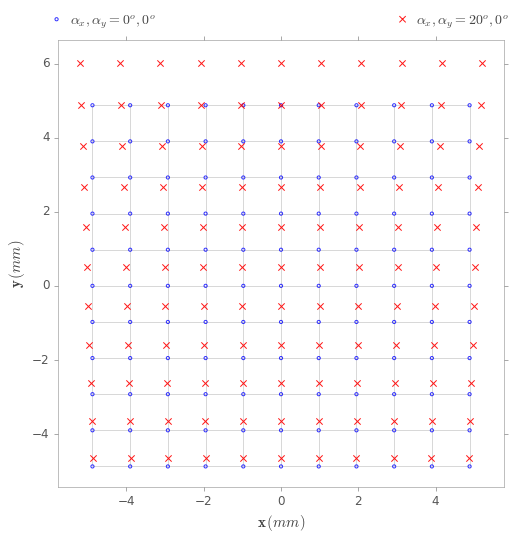

In [43]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 0)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

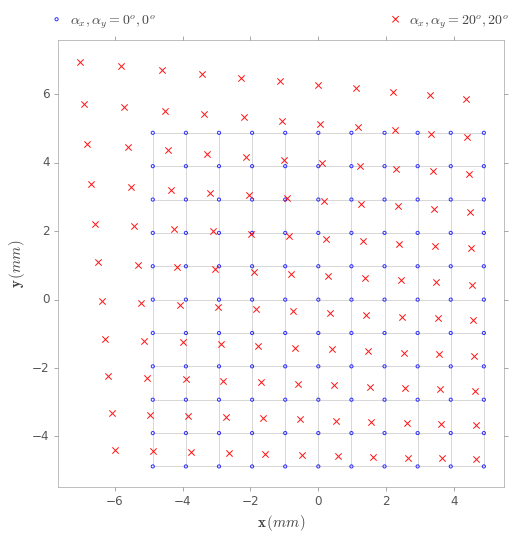

In [44]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 20)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

In [13]:
# insert coordinate break to tilt image surface
imaSurf = ln.zGetNumSurf()
ln.zInsertCoordinateBreak(surfNum=imaSurf, xtilt=15.0)
#paraxialDoubleLens24mmFiniteConj_mp2_cardinalsDrawnWdRotAboutENPPplusOffsetIIMATilt.zmx

0

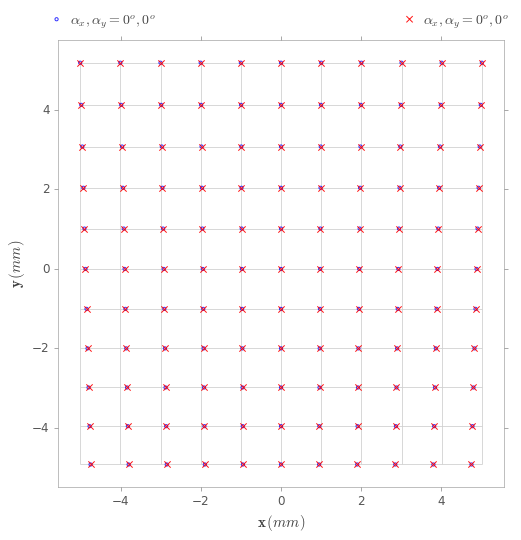

In [46]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (0, 0)]  # no lens tilt
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

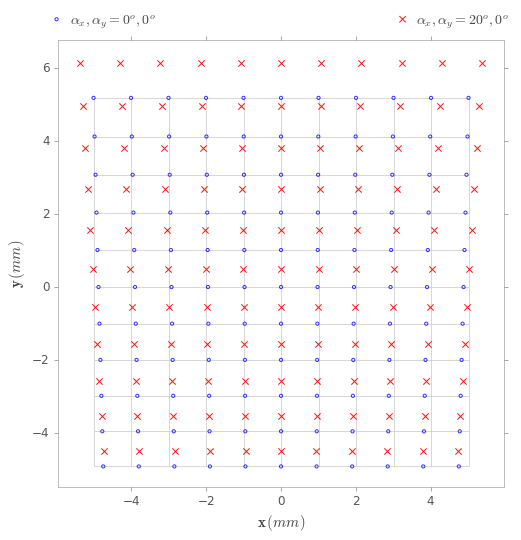

In [47]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 0)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

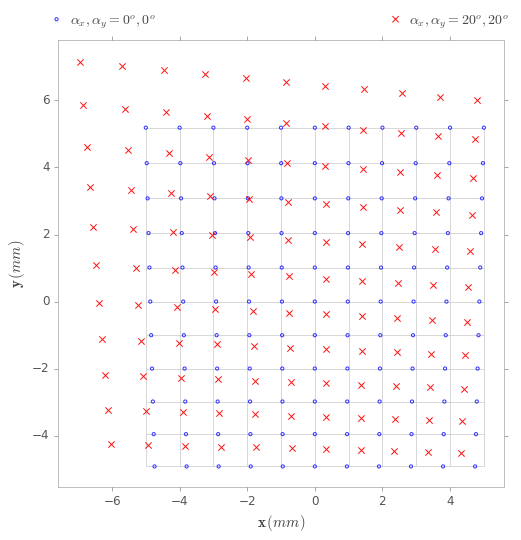

In [48]:
# plot of chief-ray intersects at the image plane 
tiltXY = [(0,0), (20, 20)]
gm.plot_chiefray_intersects(ln, cb1, tiltXY, False)

In [20]:
#ln.close()

Verification of the equation:


$$
\acute{{\bf x}} = \acute{d}_e \, {\bf r} _{l,3} + 
\frac{\left( \hat{{\bf n}}_i (3) \, \acute{z}_o  - \acute{d}_e \, \hat{{\bf n}}_i^T \, {\bf r} _{l,3} \right)}{\hat{{\bf n}}_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})}
R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3}) \,\,
$$


In the above equation both the object point and the image point are represented with respect to the camera frame ${C}$. 

$$
^{c}\acute{{\bf x}} = R_i \, ^{i}\acute{{\bf x}} + {\bf t}_i
$$

where, ${\bf t}_i = [0, 0, \acute{z}_o]^T$

Therefore, the coordinates of the image point in the image frame is


$$
^{i}\acute{{\bf x}} = R^T_i \,\left( ^{c}\acute{{\bf x}} - {\bf t}_i \right)
$$



In [14]:
# create field coordinates for ray tracing
# NOTE: 
# The following field definitions in the LDE are assumed:
# 1. The field normalization is RADIAL
# 2. The field type is object height

fieldDef = ln.zGetField(0)
assert fieldDef.type == 1       # ensure type is object height
assert fieldDef.normMethod == 0 # ensure radial normalization

# maximum radial field
fR = fieldDef.maxX # or maxY


In [15]:
## Get the positions of the ENPP, EXPP and Image plane w.r.t. the pivot
## Get the pupil magnification mp
cb1Lens = 4    # coordinate break surface number (assume that it is known)
cbImage = 22   # coordinate break surface number (assume that it is known)

# first ensure that the lens is not rotated
set_lens_image_rotations(ln, 0, 0, 0, 0, cb1Lens, cbImage)

zoDash = get_image_pos_from_pivot(ln)
de, deDash, pp = get_pupil_pos_from_pivot(ln)
mp = ln.zGetPupilMagnification()

print('Pivot position:', pp)
print('ENPP position (de):', de)
print('EXPP position (deDash):', deDash)
print('Image position (zoDash):', zoDash)
print('Pupil magnification (mp):', mp)

Pivot position: 0.0
ENPP position (de): -5.0
EXPP position (deDash): -25.0
Image position (zoDash): 24.1707317
Pupil magnification (mp): 1.99999999949


In [16]:
## Set the elemental rotations of the lens and image plane @ Zemax
# note that in Zemax the rotations are intrinsic, i.e. rotations subsequent to 
# the first rotation is always w.r.t. the new x-y-z axis.
# Also, if the order flag in the first coordinate break is 0 (default), then the
# order of rotations is: x-y'-z"

thetaXLens, thetaYLens = -20, 10
thetaXImage, thetaYImage = 15, -5
set_lens_image_rotations(ln, thetaXLens, thetaYLens, thetaXImage, thetaYImage, cb1Lens, cbImage)

In [17]:
#ln.zPushLens()

In [18]:
# Construct intrinsic rotation matrix  x-y'-z"
# This is equivalent to composition of extrinsic elemental rotations: z-y-x

Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
rl3 = Rl[:,2] # optical axis
Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
ni = Ri[:, 2] # normal to the image plane

In [19]:
# Verify using ray-tracing in Zemax
# Ensure that "ray-aiming" is on

assert ln.zGetSystem().rayAimingType
z = get_obj_pos_from_pivot(ln)
normObjPts = np.array([[ 0.0000,  0.0000], 
                       [ 0.1000, -0.1000],
                       [-0.5000,  0.5000],
                       [ 0.7071,  0.7071],
                       [ 1.0000,  0.0000],
                       [ 0.0000,  1.0000],
                       [ 1.0000,  1.0000]
                       ])

Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
numr = ni[2]*zoDash - deDash*np.dot(ni, rl3)
rmrt = np.dot(Rl , np.dot(Mp, Rl.T))

print('\t  X\t\t\t    x_computed\t\t   x_ray_trace\t\t  err(delx, dely)')
for pts in normObjPts:
    X = np.hstack((fR*pts, [z,]))
    A =  np.dot(rmrt, X - de*rl3)
    deno = np.dot(ni, A)
    x_c_est = deDash*rl3 + (numr/deno)*A   # estimate of x in camera frame
    x_est = np.dot(Ri.T, (x_c_est - np.array([0, 0, zoDash]).T))  # estimate of x in the image frame
    
    # ray trace
    rt = ln.zGetTrace(waveNum=1, mode=0, surf=-1, hx=pts[0], hy=pts[1], px=0, py=0)
    print('({: 7.2f}, {: 7.2f}, {: 5.1f}) '
          '({: .4f}, {: .4f}, {: .1f}) '
          '({: .4f}, {: .4f}, {: .1f}) '
          '({:0.1e}, {:0.1e}, {:0.1e})'
          .format(X[0], X[1], X[2],
                  x_est[0], x_est[1], x_est[2],
                  rt.x, rt.y, rt.z, 
                  abs(x_est[0] - rt.x), abs(x_est[1] - rt.y), abs(x_est[2] - rt.z)))

	  X			    x_computed		   x_ray_trace		  err(delx, dely)
(   0.00,    0.00, -509.0) (-0.3108, -0.6291,  0.0) (-0.3108, -0.6291,  0.0) (1.8e-09, 3.1e-09, 7.5e-15)
(  10.00,  -10.00, -509.0) (-0.8003, -0.0863, -0.0) (-0.8003, -0.0863,  0.0) (2.1e-09, 2.7e-09, 3.0e-15)
( -50.00,   50.00, -509.0) ( 2.1291, -3.3352,  0.0) ( 2.1291, -3.3352,  0.0) (1.2e-09, 3.2e-09, 2.9e-15)
(  70.71,   70.71, -509.0) (-4.2013, -5.0221, -0.0) (-4.2013, -5.0221,  0.0) (2.6e-09, 5.1e-09, 4.7e-15)
( 100.00,    0.00, -509.0) (-5.5251, -1.0101, -0.0) (-5.5251, -1.0101,  0.0) (1.3e-09, 8.4e-09, 3.1e-15)
(   0.00,  100.00, -509.0) (-0.6031, -6.4387, -0.0) (-0.6031, -6.4387,  0.0) (2.2e-09, 4.0e-09, 2.2e-16)
( 100.00,  100.00, -509.0) (-5.8238, -6.8542,  0.0) (-5.8238, -6.8542,  0.0) (5.6e-10, 2.5e-10, 2.2e-15)


In [21]:
ln.close()

### Patterns of image points to show the nature of image field

In [172]:
# This section of the code can run without Zemax.

def get_image_coordinates(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash):
    """returns the coordinates of the chief-ray-image-plane intersections in the image surface
    reference frame
    
    Parameters
    ----------
    X : ndarray
    
    
    """
    # construct lens rotation matrix and optical axis vector
    Rl = np.dot(rotX(thetaXLens), rotY(thetaYLens))
    rl3 = Rl[:, 2, np.newaxis]  # optical axis
    # construct image plane rotation matrix and image plane normal
    Ri = np.dot(rotX(thetaXImage), rotY(thetaYImage))
    ni = Ri[:, 2, np.newaxis]   # normal to the image plane
    # pupil magnification matrix
    Mp = np.array([[1, 0, 0], [0, 1, 0], [0, 0, mp]])
    numr = ni[2]*zoDash - deDash*np.dot(ni.T, rl3)
    rmrt = np.dot(Rl , np.dot(Mp, Rl.T))
    A =  np.dot(rmrt, X - de*rl3)  # [A]=3xn
    deno = np.dot(ni.T, A)    # [deno]=1xn
    x_c = deDash*rl3 + (numr/deno)*A   # x in camera frame
    tmpVar = x_c - np.array([0, 0, zoDash]).reshape(3,1)
    x_i = np.dot(Ri.T, (x_c - np.array([[0, 0, zoDash]]).T))  # x in the image frame
    return x_i


def plot_image_coordinates(x):
    cols = ['b', 'r', 'g', 'm', 'c', 'y']
    mkrs = ['o', 'x', '+', '1', '2', '3']
    n = 11
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=120)

            ax.scatter(x, y, marker=mkrs[i], s=40, c=cols[i], alpha=0.9, zorder=15, 
                       label=legTxt)
        else:
            ax.scatter(x, y, marker=mkrs[i], s=10, facecolors='none', 
                       edgecolors=cols[i], alpha=0.8, zorder=12, label=legTxt)
            xGridPts = x[:n]
            yGridPts = y[::n] 
            ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), 
                      zorder=2, colors='#CFCFCF', lw=0.8)
            ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), 
                      zorder=2, colors='#CFCFCF', lw=0.8)
    # finally load a new lens into the LDE
    if pushNewLens:
        ln.zNewLens()
        ln.zPushLens(1)
    ax.set_aspect('equal')
    ax.axis('tight')
    ax.set_ylabel(r'$\bf{y}\,\it{(mm)}$', fontsize=15)
    ax.set_xlabel(r'$\bf{x}\,\it{(mm)}$', fontsize=15)
    ax.legend(fontsize=14, scatterpoints=1, markerscale=1., scatteryoffsets=[0.5], mode='expand',
              ncol=len(tiltXY), loc='upper left', bbox_to_anchor=(0.09, 0.965, 0.84, 0.005), 
              bbox_transform=fig.transFigure, handletextpad=0.5, handlelength=0.9)
    plt.show()

In [189]:
# optical system parameters
z = -509.0
fR= 100
de = -5.0
deDash = -25.0
zoDash = 24.1707317
mp = 2.0

# normalized field coordinate grid
n = 11
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
X = np.vstack((fR*hx.reshape(1, n**2), fR*hy.reshape(1, n**2), z*np.ones((1, n**2))))

In [190]:
thetaXLens, thetaYLens, thetaXImage, thetaYImage = 
x = get_image_coordinates(X, thetaXLens, thetaYLens, thetaXImage, thetaYImage, mp, zoDash, de, deDash)

In [198]:
x.shape[1]

25L